Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

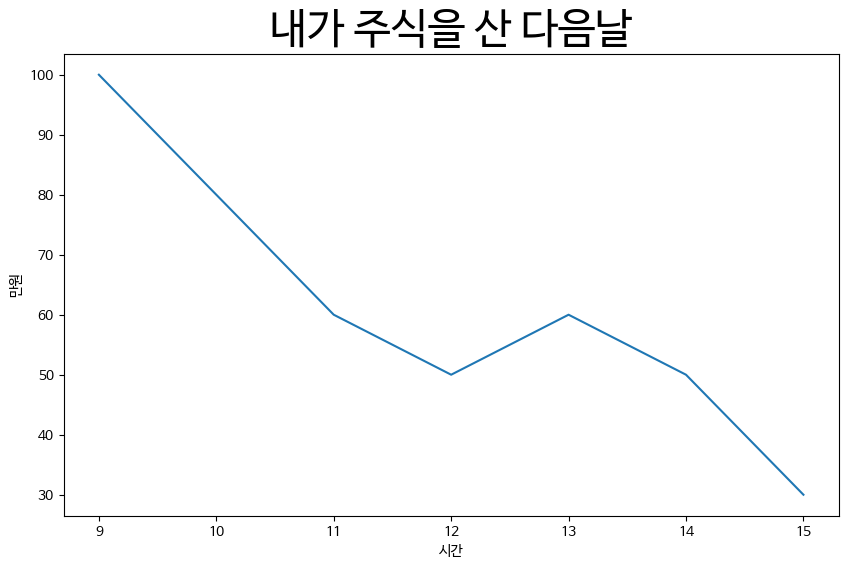

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
plt.figure(figsize=(10, 6))
plt.plot([9, 10, 11, 12, 13, 14, 15], [100, 80, 60, 50, 60, 50, 30])
plt.title('내가 주식을 산 다음날', size=30)
plt.xlabel('시간')
plt.ylabel('만원')
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install optuna pytorch-tabnet -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.0 MB/s eta 0:00:00


---

In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
from pytorch_tabnet.tab_model import TabNetClassifier
# Optuna 임포트
import optuna
from optuna.samplers import TPESampler
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과

# rc('font', family='AppleGothic') 			## 이 두 줄을
# plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다.
warnings.filterwarnings('ignore')

# 시드 설정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU 설정
if torch.backends.mps.is_available():
    device = 'mps'
    print("✓ Mac GPU 사용")
elif torch.cuda.is_available():
    device = 'cuda'
    print("✓ NVIDIA GPU 사용")
else:
    device = 'cpu'
    print("✓ CPU 사용")

✓ NVIDIA GPU 사용


In [5]:
print("\n" + "="*80)
print("1. 데이터 로드")
print("="*80)

# merged_data.csv 있는 폴더 경로 -> 수정 필요
data_path = '/content/drive/MyDrive/merged_data.csv'
df = pd.read_csv(data_path)
df = df.drop(['폐업_점포_수', '폐업_영업_개월_평균', '서울시_폐업_영업_개월_평균', '기준_년분기_코드'], axis=1)
print(f"✓ 데이터 Shape: {df.shape}")


1. 데이터 로드
✓ 데이터 Shape: (39975, 133)


In [6]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

categorical_features = ['자치구_코드_명', '서비스_업종_코드_명', '상권_변화_지표']

# 범주형 인코딩
le_district = LabelEncoder()
df['자치구_코드_명'] = le_district.fit_transform(df['자치구_코드_명'])

le_industry = LabelEncoder()
df['서비스_업종_코드_명'] = le_industry.fit_transform(df['서비스_업종_코드_명'])

le_change = LabelEncoder()
df['상권_변화_지표'] = le_change.fit_transform(df['상권_변화_지표'])

print(le_district.classes_)
print(le_industry.classes_)
print(le_change.classes_)

['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']
['PC방' '가구' '가방' '가전제품' '가전제품수리' '고시원' '골프연습장' '네일숍' '노래방' '당구장' '문구'
 '미곡판매' '미용실' '반찬가게' '부동산중개업' '분식전문점' '서적' '섬유제품' '세탁소' '수산물판매' '슈퍼마켓'
 '스포츠 강습' '스포츠클럽' '시계및귀금속' '신발' '안경' '애완동물' '양식음식점' '여관' '예술학원' '완구'
 '외국어학원' '운동/경기용품' '육류판매' '의료기기' '의약품' '인테리어' '일반교습학원' '일반의류' '일반의원'
 '일식음식점' '자동차미용' '자동차수리' '자전거 및 기타운송장비' '전자상거래업' '제과점' '조명용품' '중식음식점'
 '철물점' '청과상' '치과의원' '치킨전문점' '커피-음료' '컴퓨터및주변장치판매' '패스트푸드점' '편의점' '피부관리실'
 '한식음식점' '한의원' '핸드폰' '호프-간이주점' '화장품' '화초']
['HH' 'HL' 'LH' 'LL']


In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 전체 데이터의 75%을 기준으로 등급 나누기
df['폐업률_등급'] = pd.qcut(df['폐업_률'], q=[0, 0.75, 1.0], labels=[0, 1])

# 폐업률 2.6%을 기준으로 등급 나누기
# df['폐업률_등급'] = (df['폐업_률'] > 2.6).astype(int)

X = df.drop(['폐업_률', '폐업률_등급'], axis=1)
y_class = df['폐업률_등급']

smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(X, y_class)

X_train, X_test, y_train, y_test = train_test_split(
    X_resample, y_resample, test_size=0.2, random_state=42, stratify=y_resample
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)
print(f"y_train의 고유 값: {np.unique(X_train.iloc[:, 1])}")
# print(f"y_val의 고유 값: {np.unique(X_val[:,1])}")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

y_train의 고유 값: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
(43419, 132)
(4825, 132)
(12062, 132)


In [8]:
# 범주형 feature의 인덱스 및 차원 설정
feature_cols = [col for col in X.columns]

cat_idxs = [feature_cols.index(col) for col in categorical_features if col in feature_cols]
cat_dims = [
    len(le_district.classes_),
    len(le_industry.classes_),
    len(le_change.classes_)
]

print(cat_idxs)
print(cat_dims)

[0, 1, 51]
[25, 63, 4]


In [9]:
# 연속형 변수와 범주형 변수 분리
continuous_features = [col for col in X_train.columns if col not in categorical_features]

# StandardScaler를 사용하여 연속형 변수 스케일링
scaler = StandardScaler()

# train 데이터에 대해 fit 및 transform 수행
X_train_continuous_scaled = scaler.fit_transform(X_train[continuous_features])
X_train_continuous_scaled = pd.DataFrame(X_train_continuous_scaled, columns=continuous_features,index=X_train.index)

# val, test 데이터에 대해 transform 수행
X_val_continuous_scaled = scaler.transform(X_val[continuous_features])
X_val_continuous_scaled = pd.DataFrame(X_val_continuous_scaled, columns=continuous_features,index=X_val.index)

X_test_continuous_scaled = scaler.transform(X_test[continuous_features])
X_test_continuous_scaled = pd.DataFrame(X_test_continuous_scaled, columns=continuous_features,index=X_test.index)

# 스케일링된 연속형 변수와 범주형 변수 다시 결합
X_train_scaled = pd.concat([X_train_continuous_scaled, X_train[categorical_features]], axis=1)
X_val_scaled = pd.concat([X_val_continuous_scaled, X_val[categorical_features]], axis=1)
X_test_scaled = pd.concat([X_test_continuous_scaled, X_test[categorical_features]], axis=1)

X_train_scaled = X_train_scaled[X_train.columns]
X_val_scaled = X_val_scaled[X_val.columns]
X_test_scaled = X_test_scaled[X_test.columns]

# TabNet 모델에 입력하기 위해 numpy 배열로 변환
X_train_scaled = X_train_scaled.values
X_val_scaled = X_val_scaled.values
X_test_scaled = X_test_scaled.values

# y 데이터도 numpy 배열로 변환
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# MPS 호환성
if device == 'mps':
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_val_scaled = X_val_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)

print(f"x_train의 고유 값: {np.unique(X_train_scaled[:, 52])}")
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("y_val shape:", y_val.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

x_train의 고유 값: [-2.21363906 -2.18960009 -2.17309882 ...  3.52018129  3.52870444
  3.57096012]
X_train_scaled shape: (43419, 132)
y_train shape: (43419,)
X_val_scaled shape: (4825, 132)
y_val shape: (4825,)
X_test_scaled shape: (12062, 132)
y_test shape: (12062,)


In [10]:
# print("\n" + "="*80)
# print("9. Optuna 하이퍼파라미터 튜닝")
# print("="*80)

# def objective(trial):
#     """
#     Optuna objective 함수
#     최적의 TabNet 하이퍼파라미터를 찾기 위한 목적 함수
#     """
#     # 하이퍼파라미터 탐색 공간 정의
#     params = {
#         'n_d': trial.suggest_int('n_d', 8, 64, step=8),  # 네트워크 깊이
#         'n_steps': trial.suggest_int('n_steps', 3, 10),  # attention 단계 수
#         'gamma': trial.suggest_float('gamma', 1.0, 2.0),  # feature reusage 조절
#         'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),  # sparsity 정규화
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True),  # 학습률
#         'cat_emb_dim': trial.suggest_int('cat_emb_dim', 1, 5),  # 범주형 임베딩 차원
#     }

#     # TabNet 모델 생성
#     model = TabNetClassifier(
#         cat_idxs=cat_idxs,
#         cat_dims=cat_dims,
#         cat_emb_dim=params['cat_emb_dim'],
#         n_d=params['n_d'],
#         n_a=params['n_d'],
#         n_steps=params['n_steps'],
#         gamma=params['gamma'],
#         lambda_sparse=params['lambda_sparse'],
#         optimizer_fn=torch.optim.Adam,
#         optimizer_params=dict(lr=params['learning_rate']),
#         scheduler_params={"step_size": 50, "gamma": 0.9},
#         scheduler_fn=torch.optim.lr_scheduler.StepLR,
#         mask_type='entmax',
#         seed=SEED,
#         verbose=10,  # Optuna 실행 시 verbose 끄기
#         device_name=device,
#     )

#     # 아래 코드를 objective 함수 내부, model.fit() 직전에 붙여넣으세요.

#     print("\n" + "="*50)
#     print("!!! 데이터 정합성 검사를 시작합니다 !!!")
#     print("="*50)

#     # 모델에 들어가기 직전의 numpy 배열 데이터
#     X_to_check = X_train_scaled
#     X_val_to_check = X_val_scaled

#     # 원본 DataFrame의 컬럼 정보 (cat_idxs 계산의 기준)
#     original_columns = X_train.columns

#     error_found = False
#     # cat_idxs와 cat_dims가 이 범위에서 사용 가능해야 합니다.
#     for i, feature_idx in enumerate(cat_idxs):
#         cat_dim = cat_dims[i]
#         col_name = original_columns[feature_idx]

#         # 학습 데이터셋 검사
#         col_data_train = X_to_check[:, feature_idx]
#         min_val_train = col_data_train.min()
#         max_val_train = col_data_train.max()

#         print(f"\n검사 대상: '{col_name}' (인덱스: {feature_idx})")
#         print(f"  - 모델이 예상하는 차원 (cat_dims): {cat_dim}")
#         print(f"  - 학습 데이터의 최소/최대 값: {min_val_train} / {max_val_train}")

#         if max_val_train >= cat_dim:
#             print(f"  >>> [치명적 오류] '{col_name}'의 최대값({max_val_train})이 예상 차원({cat_dim})보다 크거나 같습니다.")
#             error_found = True

#         if min_val_train < 0:
#             print(f"  >>> [치명적 오류] '{col_name}'에서 음수 값({min_val_train})이 발견되었습니다.")
#             error_found = True

#         # 검증 데이터셋 검사
#         col_data_val = X_val_to_check[:, feature_idx]
#         min_val_val = col_data_val.min()
#         max_val_val = col_data_val.max()

#         print(f"  - 검증 데이터의 최소/최대 값: {min_val_val} / {max_val_val}")

#         if max_val_val >= cat_dim:
#             print(f"  >>> [치명적 오류] '{col_name}'의 최대값({max_val_val})이 예상 차원({cat_dim})보다 크거나 같습니다.")
#             error_found = True

#         if min_val_val < 0:
#             print(f"  >>> [치명적 오류] '{col_name}'에서 음수 값({min_val_val})이 발견되었습니다.")
#             error_found = True

#     print("\n" + "="*50)
#     if error_found:
#         print("!!! 검사 실패: Index-out-of-range 오류의 원인을 찾았습니다. '[치명적 오류]'로 표시된 변수의 데이터 처리 과정을 다시 확인하세요. !!!")
#     else:
#         print("!!! 검사 통과: 모든 범주형 변수 값들이 정상 범위 안에 있습니다. !!!")
#     print("="*50 + "\n")

#     # 모델 학습
#     model.fit(
#         X_train_scaled, y_train,
#         eval_set=[(X_val_scaled, y_val)],
#         eval_metric=['auc'],
#         max_epochs=100,  # 튜닝 시 빠른 실행을 위해 epoch 수 감소
#         patience=20,
#         batch_size=1024,
#         virtual_batch_size=128
#     )

#     # Validation AUC 반환
#     y_val_pred = model.predict_proba(X_val_scaled)
#     val_auc = roc_auc_score(y_val, y_val_pred[:, 1])

#     return val_auc

# # Optuna 스터디 생성 및 실행
# print("\nOptuna 하이퍼파라미터 튜닝 시작...")
# print("=" * 80)

# # TPE Sampler 사용 (Tree-structured Parzen Estimator)
# sampler = TPESampler(seed=SEED)
# study = optuna.create_study(
#     direction='maximize',  # AUC 최대화
#     sampler=sampler,
#     study_name='tabnet_optimization'
# )

# # 최적화 실행 (30회 trial)
# n_trials = 30
# print(f"총 {n_trials}회 trial 실행 중...\n")

# study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# # 최적 파라미터 출력
# print("\n" + "=" * 80)
# print("하이퍼파라미터 튜닝 완료")
# print("=" * 80)
# print(f"\n최고 Validation AUC: {study.best_value:.4f}")
# print(f"\n최적 하이퍼파라미터:")
# for key, value in study.best_params.items():
#     print(f"  {key}: {value}")

# # 최적 파라미터 저장
# best_params = study.best_params
# best_auc = study.best_value

In [11]:
print("\n" + "="*80)
print("10. 최적 파라미터로 최종 모델 학습")
print("="*80)
'''
최적 하이퍼파라미터:
  n_d: 64
  n_steps: 3
  gamma: 1.6580092690503243
  lambda_sparse: 1.175481510736082e-06
  learning_rate: 0.005650646614029746
  cat_emb_dim: 5
'''
# 최적 파라미터로 최종 모델 생성
final_model = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=5,
    n_d=64,
    n_a=64,
    n_steps=3,
    gamma=1.6580092690503243,
    lambda_sparse=1.175481510736082e-06,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.005650646614029746),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    seed=SEED,
    verbose=1,
    device_name=device,
)

print("\n최적 파라미터로 최종 모델 학습 시작\n")
final_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'auc', 'logloss'],
    max_epochs=200,  # 최종 모델은 충분한 epoch으로 학습
    patience=30,
    batch_size=1024,
    virtual_batch_size=128
)

print(f"\n최종 모델 학습 완료")
print(f"  - Best Epoch: {final_model.best_epoch}")
print(f"  - Best Loss: {final_model.best_cost:.6f}")


10. 최적 파라미터로 최종 모델 학습

최적 파라미터로 최종 모델 학습 시작

epoch 0  | loss: 0.8924  | val_0_accuracy: 0.62694 | val_0_auc: 0.66176 | val_0_logloss: 0.71409 |  0:00:02s
epoch 1  | loss: 0.6833  | val_0_accuracy: 0.64684 | val_0_auc: 0.70002 | val_0_logloss: 0.6473  |  0:00:04s
epoch 2  | loss: 0.62313 | val_0_accuracy: 0.69244 | val_0_auc: 0.75666 | val_0_logloss: 0.59054 |  0:00:06s
epoch 3  | loss: 0.58883 | val_0_accuracy: 0.7086  | val_0_auc: 0.77522 | val_0_logloss: 0.56713 |  0:00:08s
epoch 4  | loss: 0.57179 | val_0_accuracy: 0.71358 | val_0_auc: 0.78395 | val_0_logloss: 0.56263 |  0:00:10s
epoch 5  | loss: 0.5584  | val_0_accuracy: 0.72912 | val_0_auc: 0.79786 | val_0_logloss: 0.54819 |  0:00:15s
epoch 6  | loss: 0.5538  | val_0_accuracy: 0.72497 | val_0_auc: 0.79902 | val_0_logloss: 0.54546 |  0:00:19s
epoch 7  | loss: 0.54259 | val_0_accuracy: 0.73223 | val_0_auc: 0.80673 | val_0_logloss: 0.53648 |  0:00:21s
epoch 8  | loss: 0.53734 | val_0_accuracy: 0.74238 | val_0_auc: 0.81945 | val_0_lo

In [12]:
print("\n" + "="*80)
print("11. 튜닝된 모델 평가")
print("="*80)

# 최적 임계값 찾기
y_val_proba_tuned = final_model.predict_proba(X_val_scaled)
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba_tuned[:, 1])
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_tuned = roc_thresholds[optimal_idx]

print(f"최적 임계값: {optimal_threshold_tuned:.4f}")

# 테스트 세트 평가
y_test_proba_tuned = final_model.predict_proba(X_test_scaled)
y_test_pred_tuned = (y_test_proba_tuned[:, 1] >= optimal_threshold_tuned).astype(int)

# 평가 지표 계산
accuracy_tuned = accuracy_score(y_test, y_test_pred_tuned)
precision_tuned = precision_score(y_test, y_test_pred_tuned)
recall_tuned = recall_score(y_test, y_test_pred_tuned)
f1_tuned = f1_score(y_test, y_test_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_test_proba_tuned[:, 1])

print(f"\n{'='*80}")
print(f"튜닝된 모델 테스트 세트 성능")
print(f"{'='*80}")
print(f"  Accuracy:  {accuracy_tuned:.4f} ({accuracy_tuned*100:.2f}%)")
print(f"  Precision: {precision_tuned:.4f} ({precision_tuned*100:.2f}%)")
print(f"  Recall:    {recall_tuned:.4f} ({recall_tuned*100:.2f}%)")
print(f"  F1 Score:  {f1_tuned:.4f}")
print(f"  AUC:       {auc_tuned:.4f}")
print(f"{'='*80}")

# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)
print(f"\nConfusion Matrix:")
print(cm_tuned)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_tuned, target_names=['Low Risk', 'High Risk']))


11. 튜닝된 모델 평가
최적 임계값: 0.4669

튜닝된 모델 테스트 세트 성능
  Accuracy:  0.8309 (83.09%)
  Precision: 0.8324 (83.24%)
  Recall:    0.8286 (82.86%)
  F1 Score:  0.8305
  AUC:       0.9144

Confusion Matrix:
[[5025 1006]
 [1034 4997]]

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.83      0.83      0.83      6031
   High Risk       0.83      0.83      0.83      6031

    accuracy                           0.83     12062
   macro avg       0.83      0.83      0.83     12062
weighted avg       0.83      0.83      0.83     12062



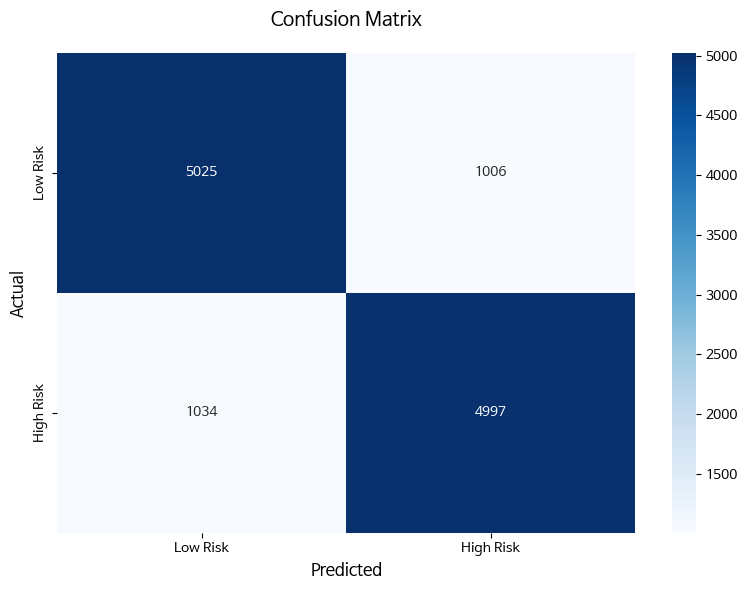

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm_tuned, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk'],
    ax=ax
)
ax.set_title('Confusion Matrix', fontsize=14, pad=20)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()


12. Feature Importance (Top 30)
         feature  importance
      프랜차이즈_점포_수    0.111078
            개업_률    0.093733
 시간대_건수~06_매출_건수    0.087600
       목요일_매출_건수    0.043944
 서울시_운영_영업_개월_평균    0.043892
        총_직장인구_수    0.038214
       월요일_매출_금액    0.037966
      유사_업종_점포_수    0.032412
 시간대_21_24_매출_금액    0.032055
     서비스_업종_코드_명    0.030881
       기타_지출_총금액    0.025454
       화요일_매출_건수    0.023430
 시간대_건수~21_매출_건수    0.022686
여성연령대_30_직장_인구_수    0.019692
       토요일_매출_건수    0.018028
연령대_60_이상_유동인구_수    0.016128
 시간대_17_21_매출_금액    0.015947
    연령대_50_매출_금액    0.015208
   연령대_10_직장인구_수    0.013775
        남성_매출_건수    0.013588
 시간대_건수~14_매출_건수    0.012832
    연령대_40_매출_건수    0.010609
 시간대_11_14_매출_금액    0.010410
 시간대_06_11_매출_금액    0.010388
    연령대_10_매출_금액    0.010239
        여성_매출_금액    0.009711
    연령대_20_매출_건수    0.009370
       남성_유동인구_수    0.008894
       음식_지출_총금액    0.007868
시간대_11_14_유동인구_수    0.007233


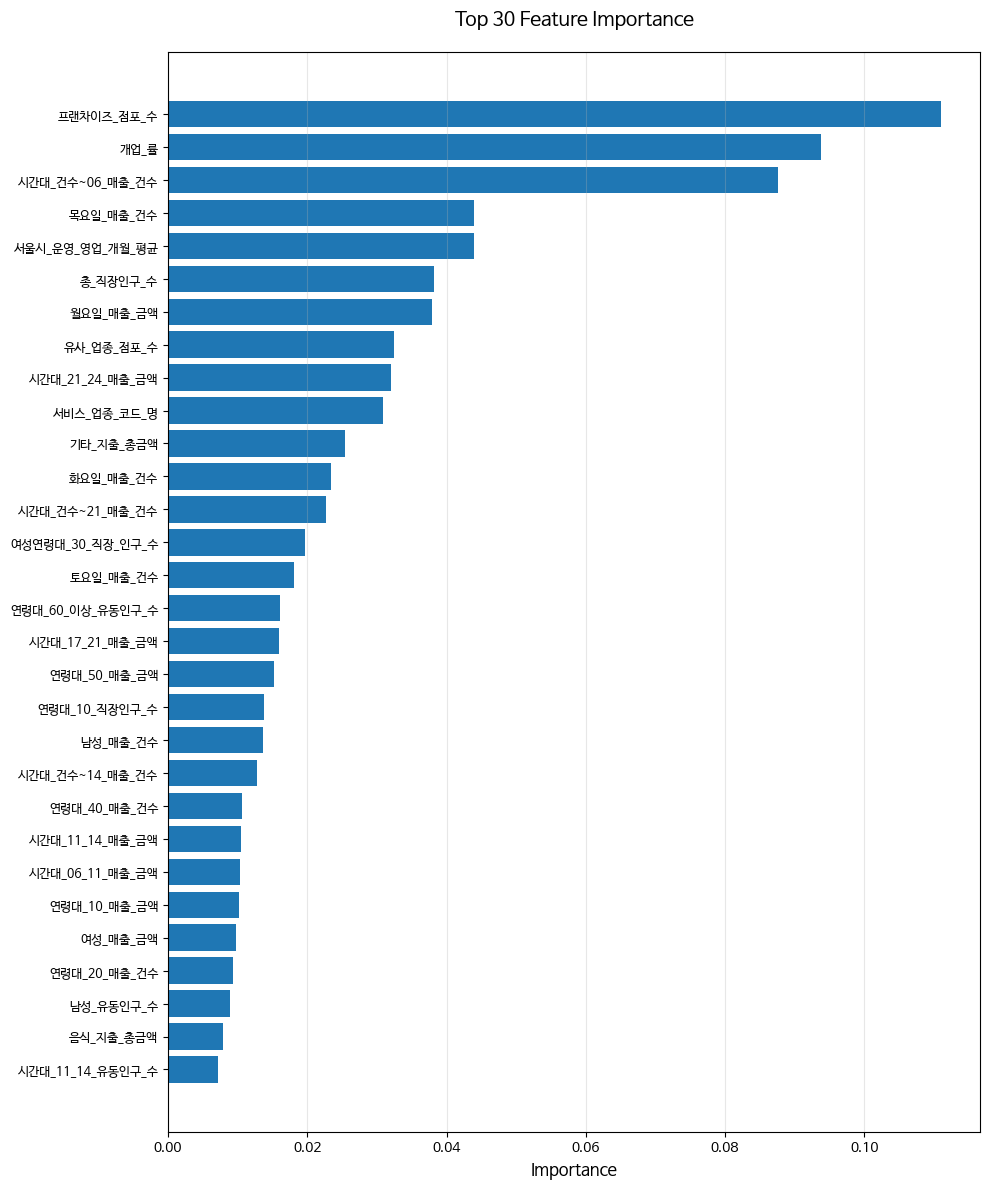

In [14]:
print("\n" + "="*80)
print("12. Feature Importance (Top 30)")
print("="*80)

feature_importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=False).head(30)

print(importance_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(10, 12))
ax.barh(range(len(importance_df)), importance_df['importance'])
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 30 Feature Importance', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

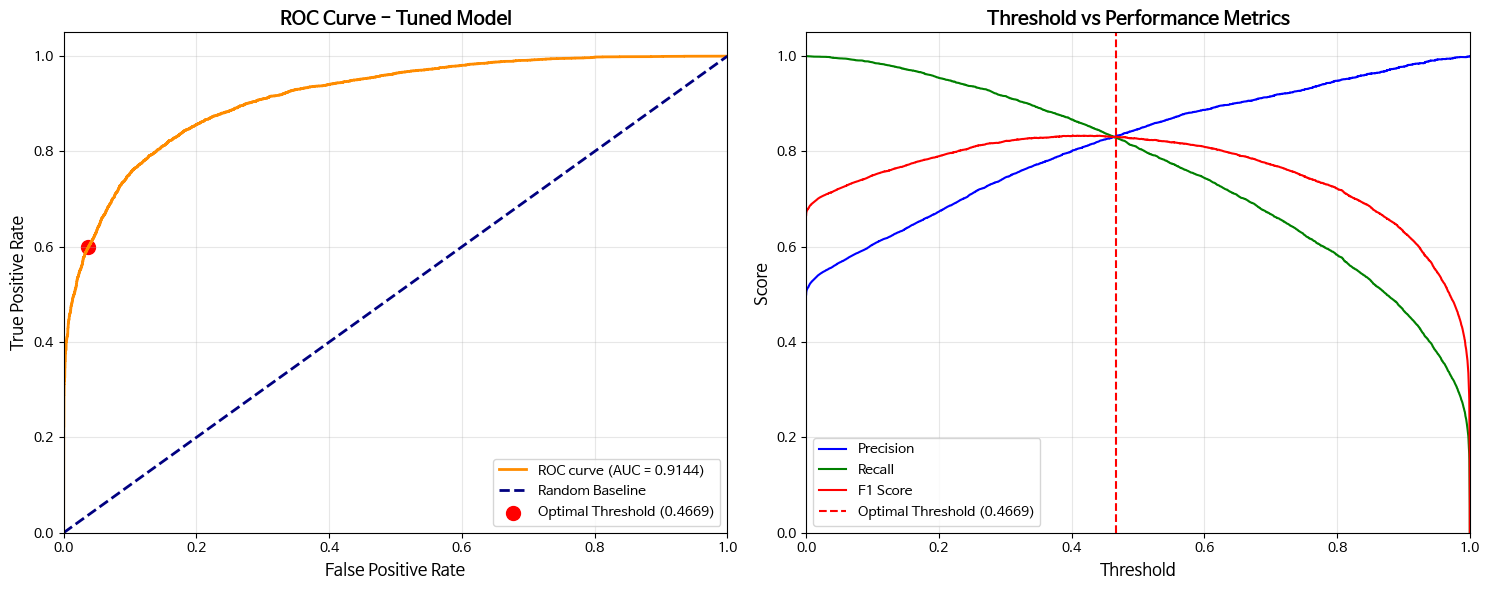

In [19]:
# ROC Curve 시각화

from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. ROC Curve
ax1 = axes[0]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_tuned[:, 1])
auc_score = auc(fpr, tpr)

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100,
           label=f'Optimal Threshold ({optimal_threshold_tuned:.4f})')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - Tuned Model', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Threshold vs Metrics
ax2 = axes[1]
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba_tuned[:, 1])
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

ax2.plot(pr_thresholds, precision[:-1], 'b-', label='Precision')
ax2.plot(pr_thresholds, recall[:-1], 'g-', label='Recall')
ax2.plot(pr_thresholds, f1_scores, 'r-', label='F1 Score')
ax2.axvline(x=optimal_threshold_tuned, color='red', linestyle='--',
           label=f'Optimal Threshold ({optimal_threshold_tuned:.4f})')

ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Threshold vs Performance Metrics', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [15]:
# # 모델 저장
# model.save_model('./models/tabnet_ver3_model')
# print("모델 저장 완료: ./models/tabnet_ver3_model.zip")

# # Feature 정보 저장
# feature_info = {
#     'feature_cols': feature_cols,
#     'cat_idxs': cat_idxs,
#     'cat_dims': cat_dims,
#     'optimal_threshold': optimal_threshold
# }

# import pickle
# with open('./models/tabnet_ver3_feature_info.pkl', 'wb') as f:
#     pickle.dump(feature_info, f)
# print("Feature 정보 저장 완료: ./models/tabnet_ver3_feature_info.pkl")